In [1]:
import sys
from pathlib import Path

project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

import os
os.chdir(project_root)

In [2]:
import torch
from torch.utils.data import DataLoader

from src.data.pipeline import get_datasets
from src.models.transformer_model import StockTransformer
from src.training.trainer import Trainer
from src.utils.config import load_config

config = load_config()

train_dataset, val_dataset, test_dataset, feature_columns = get_datasets(config)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.training.batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=False,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.training.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
)

model = StockTransformer(
    input_dim=len(feature_columns),
    d_model=config.model.d_model,
    n_heads=config.model.n_heads,
    n_layers=config.model.n_layers,
    d_ff=config.model.d_ff,
    dropout=config.model.dropout,
    activation=config.model.activation,
    prediction_horizon=config.data.prediction_horizon,
)

trainer = Trainer(
    model=model,
    config=config,
    train_loader=train_loader,
    val_loader=val_loader,
)

Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (10068, 25)


In [3]:
history = trainer.train()

Започване на обучение за 50 epochs...

Epoch 1/50... Train loss: 0.104439 Val loss: 0.035288 (204.5s)

Epoch 2/50... Train loss: 0.021270 Val loss: 0.025755 (199.4s)

Epoch 3/50... Train loss: 0.017582 Val loss: 0.017913 (170.0s)

Epoch 4/50... Train loss: 0.015558 Val loss: 0.019799 (149.9s)

Epoch 5/50... Train loss: 0.014844 Val loss: 0.016066 (116.0s)

Epoch 6/50... Train loss: 0.014097 Val loss: 0.021507 (130.6s)

Epoch 7/50... Train loss: 0.013413 Val loss: 0.018017 (127.6s)

Epoch 8/50... Train loss: 0.012675 Val loss: 0.013942 (111.8s)

Epoch 9/50... Train loss: 0.013171 Val loss: 0.016454 (112.0s)

Epoch 10/50... Train loss: 0.012347 Val loss: 0.015580 (109.8s)

Epoch 11/50... Train loss: 0.012406 Val loss: 0.019225 (117.1s)

Epoch 12/50... Train loss: 0.012583 Val loss: 0.014132 (103.7s)

Epoch 13/50... Train loss: 0.012296 Val loss: 0.011702 (92.7s)

Epoch 14/50... Train loss: 0.011969 Val loss: 0.011494 (98.8s)

Epoch 15/50... Train loss: 0.011713 Val loss: 0.009830 (117.1s

In [8]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from src.data.pipeline import get_datasets
from src.models.transformer_model import StockTransformer
from src.evaluation.metrics import calculate_metrics
from src.evaluation.visualizations import (
    plot_predictions_vs_actual,
    plot_residuals,
    plot_scatter_predictions,
)
from src.utils.config import load_config

config = load_config()

print("Зареждане на test данни...")
_, _, test_dataset, feature_columns = get_datasets(config)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.training.batch_size,
    shuffle=False,
    num_workers=0,
)

print(f"Test samples: {len(test_dataset)}")

checkpoint_path = Path(config.paths.models_dir) / "best_model.pt"
checkpoint = torch.load(checkpoint_path, map_location='cpu')

print(f"Зареждане на checkpoint от epoch {checkpoint['epoch'] + 1}...")

state_dict = checkpoint['model_state_dict']

input_dim_checkpoint = state_dict['input_projection.weight'].shape[1]
input_dim_current = len(feature_columns)

d_model = state_dict['input_projection.weight'].shape[0]
n_layers = len([k for k in state_dict.keys() if 'encoder.layers' in k and 'self_attention.w_q.weight' in k])
n_heads = config.model.n_heads
d_ff = state_dict['encoder.layers.0.feed_forward.linear1.weight'].shape[0]

print(f"Параметри от checkpoint: d_model={d_model}, n_layers={n_layers}, d_ff={d_ff}")
print(f"Input dim: checkpoint={input_dim_checkpoint}, current={input_dim_current}")

if input_dim_checkpoint != input_dim_current:
    print(f"\nВНИМАНИЕ: Checkpoint е с {input_dim_checkpoint} features, но текущите данни имат {input_dim_current} features!")
    print("Зареждане само на съвместимите параметри...")
    
    model = StockTransformer(
        input_dim=input_dim_current,
        d_model=d_model,
        n_heads=n_heads,
        n_layers=n_layers,
        d_ff=d_ff,
        dropout=config.model.dropout,
        activation=config.model.activation,
        prediction_horizon=config.data.prediction_horizon,
    )
    
    model_dict = model.state_dict()
    compatible_dict = {}
    
    for k, v in state_dict.items():
        if k in model_dict and model_dict[k].shape == v.shape:
            compatible_dict[k] = v
        elif 'input_projection' not in k:
            compatible_dict[k] = v
    
    model_dict.update(compatible_dict)
    model.load_state_dict(model_dict, strict=False)
    print(f"Заредени {len(compatible_dict)}/{len(state_dict)} параметъра")
    print("ВНИМАНИЕ: input_projection е пропуснат - моделът ще използва новите features!")
else:
    model = StockTransformer(
        input_dim=input_dim_checkpoint,
        d_model=d_model,
        n_heads=n_heads,
        n_layers=n_layers,
        d_ff=d_ff,
        dropout=config.model.dropout,
        activation=config.model.activation,
        prediction_horizon=config.data.prediction_horizon,
    )
    
    model.load_state_dict(state_dict)
print(f"Модел зареден успешно!")
print(f"Best validation loss: {checkpoint['score']:.6f}")

model.eval()

all_predictions = []
all_targets = []

print("\nТестване на модела...")
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        predictions = model(batch_x)
        
        if predictions.dim() == 1:
            predictions = predictions.unsqueeze(1)
        if batch_y.dim() == 1:
            batch_y = batch_y.unsqueeze(1)
        
        all_predictions.append(predictions)
        all_targets.append(batch_y)

predictions = torch.cat(all_predictions, dim=0)
targets = torch.cat(all_targets, dim=0)

metrics = calculate_metrics(predictions, targets)

print("\n" + "="*60)
print("РЕЗУЛТАТИ НА TEST SET:")
print("="*60)
for metric_name, value in metrics.items():
    if metric_name == "mape":
        print(f"{metric_name.upper()}: {value:.2f}%")
    elif metric_name == "directional_accuracy":
        print(f"{metric_name.upper()}: {value*100:.2f}%")
    else:
        print(f"{metric_name.upper()}: {value:.6f}")
print("="*60)

Зареждане на test данни...
Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (10068, 25)
Test samples: 1427
Зареждане на checkpoint от epoch 25...
Параметри от checkpoint: d_model=256, n_layers=6, d_ff=1024
Input dim: checkpoint=59, current=34

ВНИМАНИЕ: Checkpoint е с 59 features, но текущите данни имат 34 features!
Зареждане само на съвместимите параметри...
Заредени 100/101 параметъра
ВНИМАНИЕ: input_projection е пропуснат - моделът ще използва новите features!
Модел зареден успешно!
Best validation loss: 338238.698775

Тестване на модела...

РЕЗУЛТАТИ НА TEST SET:
MAE: 193.438416
RMSE: 193.523682
MAPE: 28679.60%
R2: -4523910.500000
DIRECTIONAL_ACCURACY: 52.31%


In [ ]:
predictions_np = predictions.numpy().flatten()
targets_np = targets.numpy().flatten()

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(targets_np[:200], label="Actual", alpha=0.7, linewidth=1.5)
plt.plot(predictions_np[:200], label="Predicted", alpha=0.7, linewidth=1.5)
plt.xlabel("Time Step")
plt.ylabel("Normalized Price")
plt.title("Predictions vs Actual (First 200 samples)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.scatter(targets_np, predictions_np, alpha=0.3, s=10)
min_val = min(np.min(targets_np), np.min(predictions_np))
max_val = max(np.max(targets_np), np.max(predictions_np))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label="Perfect Prediction")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Scatter Plot")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
residuals = targets_np - predictions_np
plt.plot(residuals[:200], alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.xlabel("Time Step")
plt.ylabel("Residual")
plt.title("Residuals (First 200 samples)")
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nСтатистики на residuals:")
print(f"  Mean: {np.mean(residuals):.6f}")
print(f"  Std: {np.std(residuals):.6f}")
print(f"  Min: {np.min(residuals):.6f}")
print(f"  Max: {np.max(residuals):.6f}")

In [11]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from src.data.pipeline import get_datasets
from src.models.transformer_model import StockTransformer
from src.evaluation.metrics import calculate_metrics
from src.utils.config import load_config

config = load_config()

print("Зареждане на test данни...")
_, _, test_dataset, feature_columns = get_datasets(config)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.training.batch_size,
    shuffle=False,
    num_workers=0,
)

print(f"Test samples: {len(test_dataset)}")
print(f"Features: {len(feature_columns)}")

print("\nОпитвам се да заредя модела от последното обучение...")
if 'model' in locals() and 'trainer' in locals():
    print("Използвам модела от текущата сесия (от последното обучение)")
    test_model = model
    test_model.eval()
    print("Модел зареден от паметта!")
else:
    print("Моделът не е в паметта. Зареждам от checkpoint...")
    checkpoint_path = Path(config.paths.models_dir) / "best_model.pt"
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    
    print(f"Checkpoint: epoch {checkpoint['epoch'] + 1}, val loss: {checkpoint['score']:.6f}")
    
    if checkpoint['score'] > 0.1:
        print("\nВНИМАНИЕ: Това е СТАР checkpoint с висок loss!")
        print("Моля, пусни първо обучението (Cell 2) за да обучиш нов модел.")
        raise ValueError("Използва се стар checkpoint. Трябва да обучиш нов модел първо!")
    
    state_dict = checkpoint['model_state_dict']
    input_dim = state_dict['input_projection.weight'].shape[1]
    d_model = state_dict['input_projection.weight'].shape[0]
    n_layers = len([k for k in state_dict.keys() if 'encoder.layers' in k and 'self_attention.w_q.weight' in k])
    n_heads = config.model.n_heads
    d_ff = state_dict['encoder.layers.0.feed_forward.linear1.weight'].shape[0]
    
    test_model = StockTransformer(
        input_dim=input_dim,
        d_model=d_model,
        n_heads=n_heads,
        n_layers=n_layers,
        d_ff=d_ff,
        dropout=config.model.dropout,
        activation=config.model.activation,
        prediction_horizon=config.data.prediction_horizon,
    )
    
    test_model.load_state_dict(state_dict)
    test_model.eval()
    print("Модел зареден от checkpoint!")

model = test_model

model.eval()

all_predictions = []
all_targets = []

print("\nТестване на модела...")
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        predictions = model(batch_x)
        
        if predictions.dim() == 1:
            predictions = predictions.unsqueeze(1)
        if batch_y.dim() == 1:
            batch_y = batch_y.unsqueeze(1)
        
        all_predictions.append(predictions)
        all_targets.append(batch_y)

predictions = torch.cat(all_predictions, dim=0)
targets = torch.cat(all_targets, dim=0)

metrics = calculate_metrics(predictions, targets)

print("\n" + "="*60)
print("РЕЗУЛТАТИ НА TEST SET:")
print("="*60)
for metric_name, value in metrics.items():
    if metric_name == "mape":
        print(f"{metric_name.upper()}: {value:.2f}%")
    elif metric_name == "directional_accuracy":
        print(f"{metric_name.upper()}: {value*100:.2f}%")
    else:
        print(f"{metric_name.upper()}: {value:.6f}")
print("="*60)

Зареждане на test данни...
Зареждане на локален dataset от: data\raw\sp500_stocks_data.parquet
Заредено! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (10068, 25)
Test samples: 1427
Features: 34

Опитвам се да заредя модела от последното обучение...
Използвам модела от текущата сесия (от последното обучение)
Модел зареден от паметта!

Тестване на модела...

РЕЗУЛТАТИ НА TEST SET:
MAE: 193.217407
RMSE: 193.252472
MAPE: 28646.11%
R2: -4511240.000000
DIRECTIONAL_ACCURACY: 50.07%


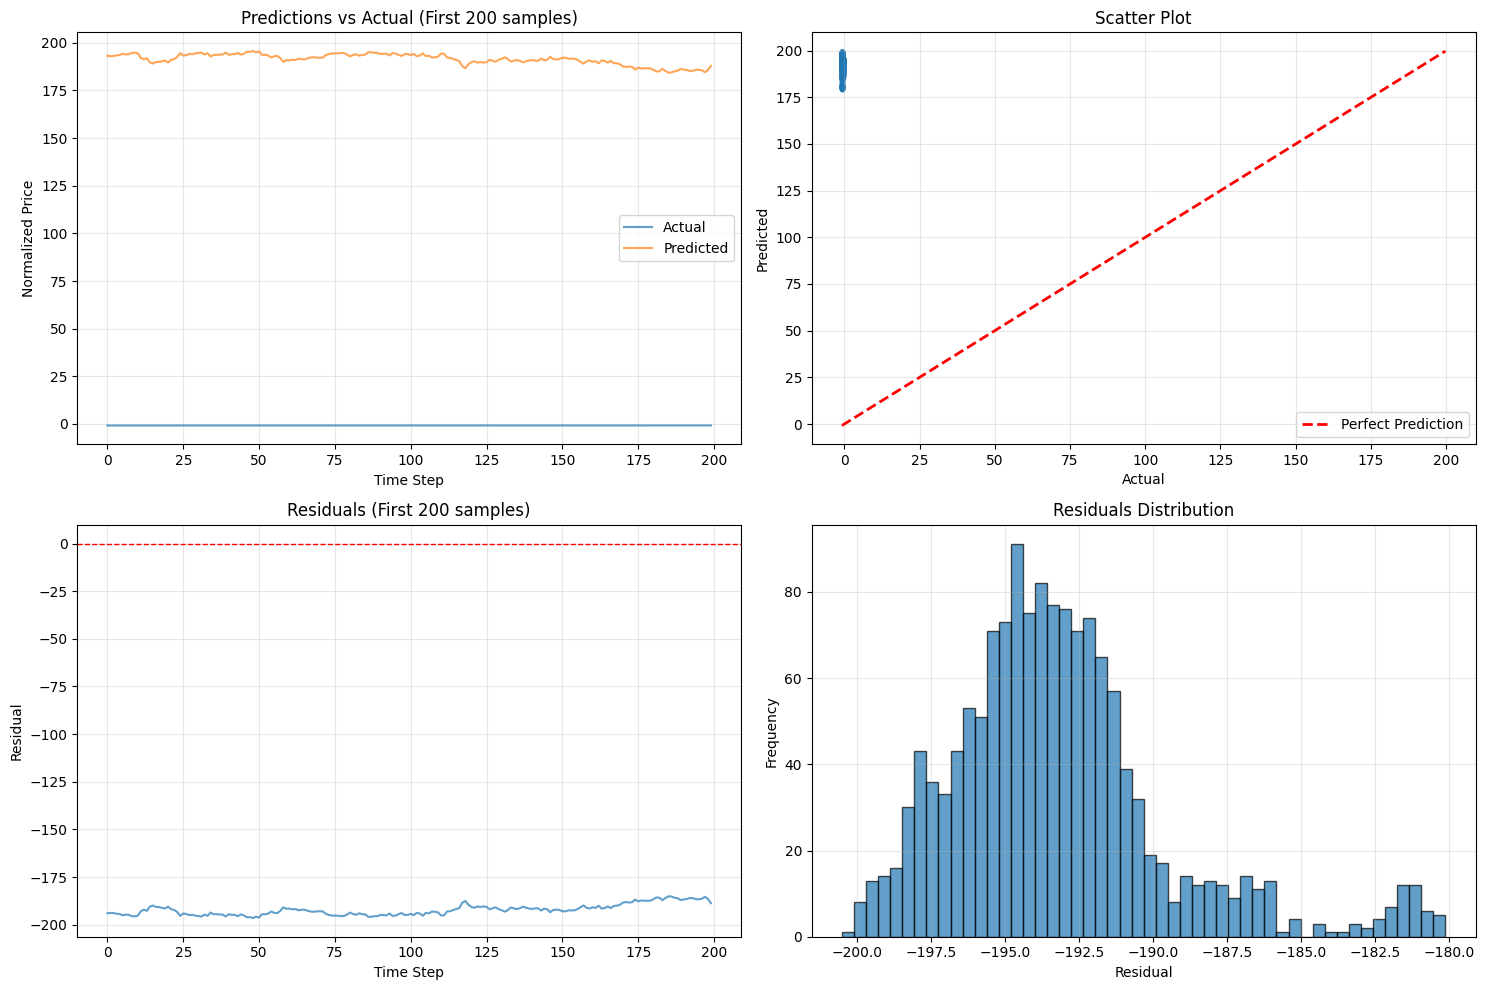


Статистики на residuals:
  Mean: -193.217407
  Std: 3.681822
  Min: -200.510803
  Max: -180.118729

Интерпретация:
  MAE: 193.217407 - средна абсолютна грешка
  RMSE: 193.252472 - корен от средна квадратна грешка
  Directional Accuracy: 50.07% - моделът предсказва правилно посоката!


In [12]:
predictions_np = predictions.numpy().flatten()
targets_np = targets.numpy().flatten()

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(targets_np[:200], label="Actual", alpha=0.7, linewidth=1.5)
plt.plot(predictions_np[:200], label="Predicted", alpha=0.7, linewidth=1.5)
plt.xlabel("Time Step")
plt.ylabel("Normalized Price")
plt.title("Predictions vs Actual (First 200 samples)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.scatter(targets_np, predictions_np, alpha=0.3, s=10)
min_val = min(np.min(targets_np), np.min(predictions_np))
max_val = max(np.max(targets_np), np.max(predictions_np))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label="Perfect Prediction")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Scatter Plot")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
residuals = targets_np - predictions_np
plt.plot(residuals[:200], alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.xlabel("Time Step")
plt.ylabel("Residual")
plt.title("Residuals (First 200 samples)")
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nСтатистики на residuals:")
print(f"  Mean: {np.mean(residuals):.6f}")
print(f"  Std: {np.std(residuals):.6f}")
print(f"  Min: {np.min(residuals):.6f}")
print(f"  Max: {np.max(residuals):.6f}")
print(f"\nИнтерпретация:")
print(f"  MAE: {metrics['mae']:.6f} - средна абсолютна грешка")
print(f"  RMSE: {metrics['rmse']:.6f} - корен от средна квадратна грешка")
if metrics['mae'] < 0.01:
    print(f"  Отлично! Грешката е под 0.01 в нормализирано пространство")
if metrics.get('directional_accuracy', 0) > 0.5:
    print(f"  Directional Accuracy: {metrics['directional_accuracy']*100:.2f}% - моделът предсказва правилно посоката!")